# Demo

Demo to assess the performance of XRNN for transfer wells completely unseen by the model. I.E. the XRNN has seen only data from the training period for the training wells. 

Note: average RMSE from synthetic noise is 0.0199548.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

import dataloader
import util
import xrnn
import plotter
import comparer

Using TensorFlow backend.


In [2]:
#load formatted data
n_lag = 3
n_seq = 6
ref_case = 6       #out of n_samples
n_samples = 300

Bakken = dataloader.DataLoader(n_samples, n_lag, n_seq, verbose=False)
Bakken.load_data(flip=False)

#train and test refers to the same well. 
#for x-rnn, we need to further split it to train (some wells) and test (some other wells)
x_train, x_test, y_train, y_test = Bakken.get_time_series_xrnn(split=0.95)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#qc time windows (comment if n_samples is > 10)
#util.qc_timeseries_windows(y_train, y_test, n_lag, n_seq)

(14700, 6) (900, 6) (14700, 9, 3) (900, 9, 3)


In [3]:
#transfer data (the other half from the lower half)
Bakken_transfer = dataloader.DataLoader(n_samples, n_lag, n_seq, verbose=False)
Bakken_transfer.load_data(flip=True)
x_transfer, _, y_transfer, y_transfer_test = Bakken_transfer.get_time_series_xrnn(split=0.95)

#util.qc_timeseries_windows(y_transfer, y_transfer_test, n_lag, n_seq)

x and y flipped


In [4]:
#train model 
xrnn_model = xrnn.XRNN(x_train, y_train, n_lag=n_lag, n_seq=n_seq, name="Demo-xrnn-transfer")
xrnn_model.train(n_batch=1, nb_epoch=50, load=True)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (1, 6)               0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1, 5)               35          input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (1, 5)               0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (1, 4)               24          leaky_re_lu_1[0][0]    

In [5]:
#get forecasts for training and testing 
forecasts_test = np.array(xrnn_model.forecasts(x_test, y_test))
forecasts_train = np.array(xrnn_model.forecasts(x_train, y_train))

#for transfer, y_test is not meaningful as its short
_ = util.evaluate_forecasts(y_train[:, n_lag:, :], forecasts_train)

#get multi-step forecasts for all 'n_samples' wells
n_steps = 3
forecasts_test_multi = xrnn_model.forecasts_multistep_all(x_test, y_test, n_samples, n_steps=n_steps)

t+1 RMSE: 0.027940
t+2 RMSE: 0.027925
t+3 RMSE: 0.027823
t+4 RMSE: 0.027892
t+5 RMSE: 0.027939
t+6 RMSE: 0.028232


294 343 18 21
(60,) (49, 6) (49, 6) (3, 6) (3, 6) (3, 6)
294 343 18 21
(60,) (49, 6) (49, 6) (3, 6) (3, 6) (3, 6)
294 343 18 21
(60,) (49, 6) (49, 6) (3, 6) (3, 6) (3, 6)


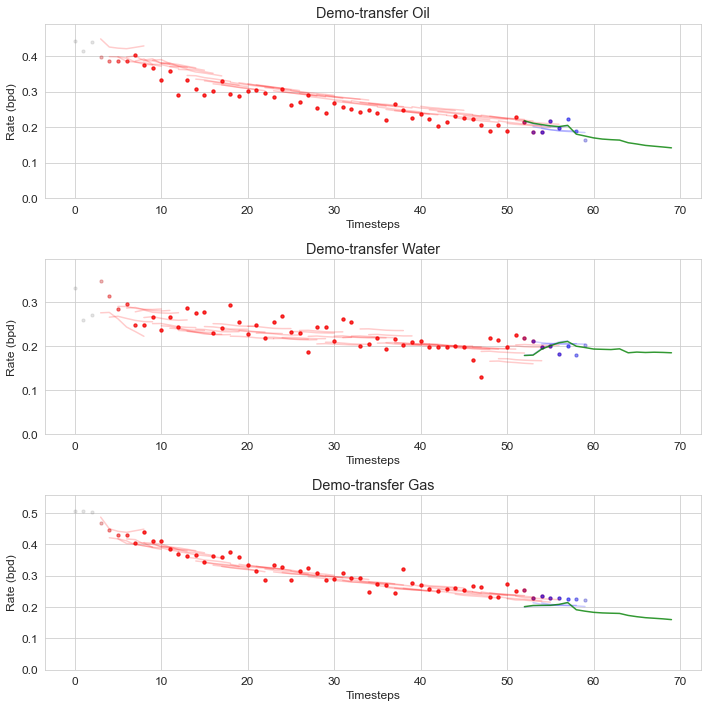

In [6]:
#for the same well, compare train and test periods
plot = plotter.Plotter(n_samples, n_lag, n_seq, y_train, y_test, Bakken.y_noisy, forecasts_train, forecasts_test, forecasts_test_multi)

plot.plot_profiles_nontransfer(ref_case, name='Demo-transfer ')

In [7]:
#get forecasts for the transfer dataset, n_steps must cover the entire range
n_steps = 15
forecasts_multi_transfer = xrnn_model.forecasts_multistep_all(x_transfer, y_transfer, n_samples, n_steps=n_steps)

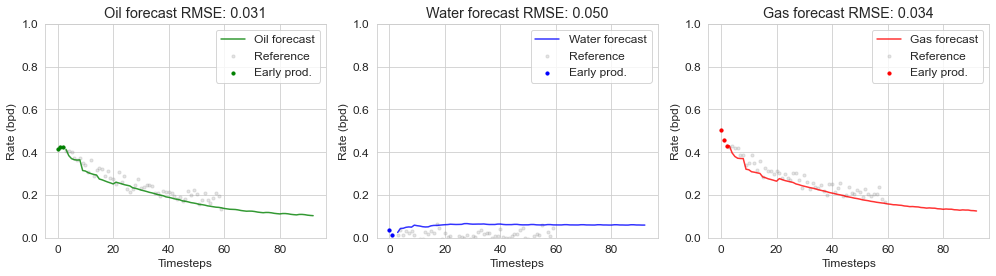

In [8]:
#any case from the transfer dataset
ref_case_transfer = 63

#view predictions
plotter.plot_profiles_transfer(Bakken_transfer.y_noisy[ref_case_transfer], n_lag, n_seq, forecasts_multi_transfer[ref_case_transfer], "xrnn_forecasts_transfer")

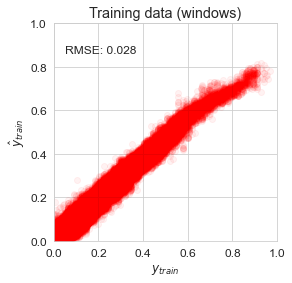

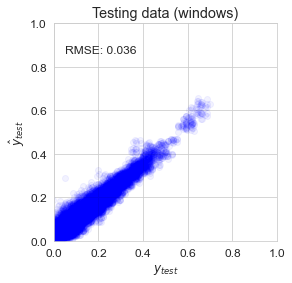

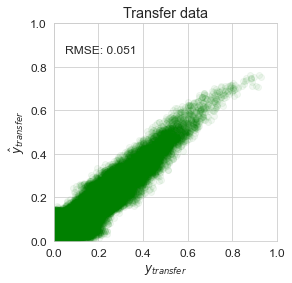

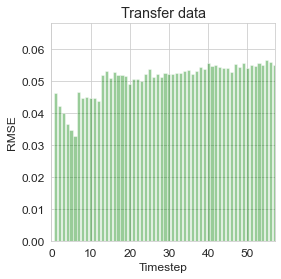

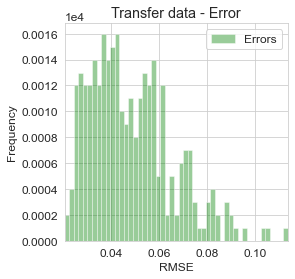

In [9]:
util.qc_timeseries_stats(y_train, forecasts_train, y_test, forecasts_test, np.array(Bakken_transfer.y_noisy), forecasts_multi_transfer, n_lag, n_seq)

## Spatial relationship between original data and transfer data

Assess the relevance of the original data used to train the XRNN model with respect to the transfer data. In this synthetic case, we expect it to be 100% relevant (since the original and transfer data both come from the same set).

(600, 6) (600, 60, 3) (600,)


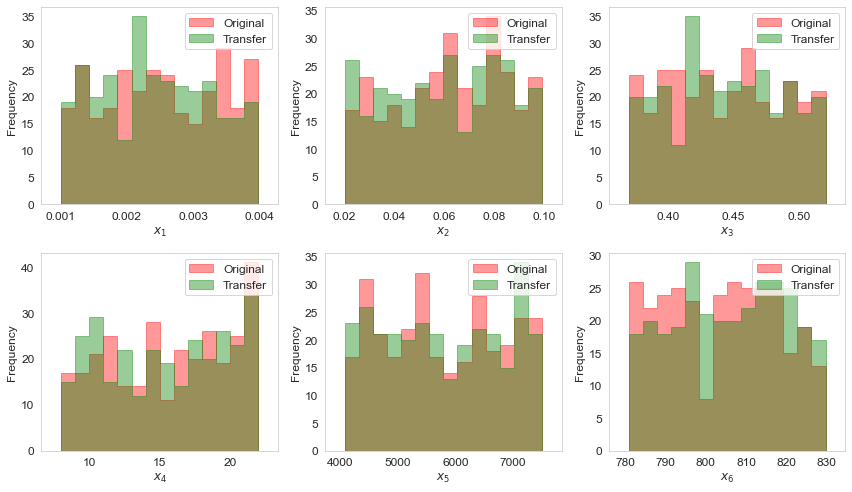

In [10]:
#combine original and transfer dataset, create identifying labels
x = np.concatenate((Bakken.x_raw[0:n_samples], Bakken_transfer.x_raw[-n_samples:]))
y = np.concatenate((Bakken.y_raw[0:n_samples], Bakken_transfer.y_raw[-n_samples:]))
labels = np.zeros([x.shape[0],])
labels[0:n_samples] = 0
labels[-n_samples:] = 1
print(x.shape, y.shape, labels.shape)

col_names = ['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', '$x_6$']
class_names = ['Original', 'Transfer']

comp = comparer.Comparer(x, y, labels, col_names, class_names, 'Demo-xrnn-transfer')
comp.plot_properties()

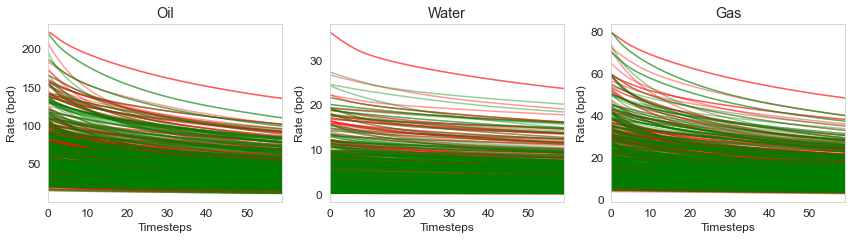

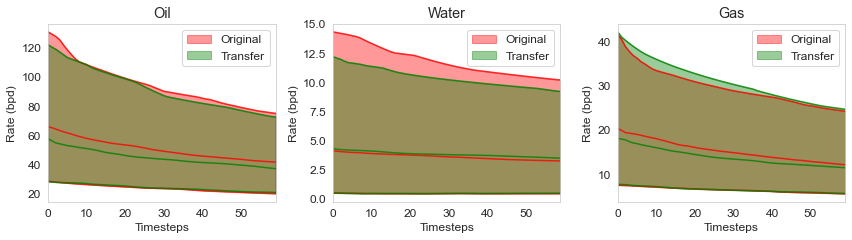

In [11]:
comp.plot_production()
comp.plot_production_percentiles()

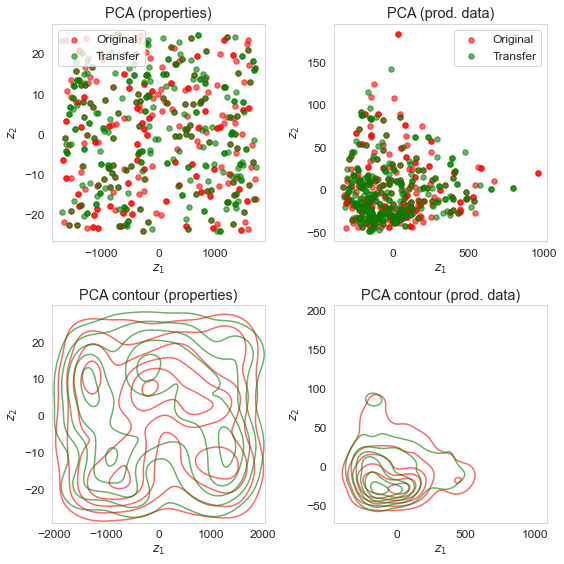

In [12]:
comp.plot_pca()